# Movie reviews (IMDB)
### Sentiment Analysis Using RNN - LTSM

Steps:

1. Importing/Installing tensorflow and other packages on your system and defining functions
2. Loading your data from disk
3. Data Preprocessing and visualization
4. Creating your training & testing splits and the text encoder
5. Defining your RNN model architecture
6. Compiling your RNN model
7. Training your model on your training data
8. Evaluating your model on your test data
9. Saving our model
10. Making predictions for unseen data
11. confusion matrix & Classification report
12. Final submission

### 1. Importing packages on your system

In [1]:
# Time to run
import time
start_time = time.time()

# import libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , accuracy_score, classification_report
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense,LSTM , GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import  Embedding
from tensorflow.keras.models import Sequential
import tensorflow as tf
import itertools
from tensorflow.keras.models import load_model

import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

print("Tensorflow Version: {}".format(tf.__version__))

Tensorflow Version: 2.11.0


#### Functions Used

In [2]:
def clean_review(text):
    '''
    Utility function to clean review text by removing links, special characters
    using simple regex statements.
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", text).split()).lower()

def plot_confusion_metrix(y_true, y_pred,classes,
                         normalize=False,
                         title='Confusion Matrix',
                         cmap=plt.cm.Blues):
    """
    Objective
    ----------
    plot confussion matrix, classification report and accuracy score

    parameters
    ----------
    y_true : array-like of shape (n_samples,)
        Ground truth (correct) target values.

    y_pred : array-like of shape (n_samples,)
        Estimated targets as returned by a classifier.

    classes : list
        List of labels to index the matrix

    title : title for matrix
    cmap : colormap for matrix

    returns
    ----------
   all accruacy matrix
    """


    cm = confusion_matrix(y_true,y_pred)


    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print("Confusion Matrix, Without Normalisation")


    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=35)
    plt.yticks(tick_marks,classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() /2.

    for i , j in itertools.product(range(cm.shape[0]), range(cm.shape[0])):
        plt.text(j, i, format(cm[i,j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    # plt.tight_layout()

    plt.show()

    print("-----------------------------------------------------")
    print('Classification report')
    print(classification_report(y_true,y_pred))

    print("-----------------------------------------------------")
    acc= accuracy_score(y_true,y_pred)
    print("Accuracy of the model: ", acc)
    
def calculate_execution_time(start_time, end_time):
    execution_time = end_time - start_time  # Time in seconds
    minutes, seconds = divmod(execution_time, 60)  # Extracting minutes and seconds
    return f"Execution time: {int(minutes)} minutes and {seconds:.2f} seconds"

### 2. Load data from disk

In [3]:
df = pd.read_csv("IMDB Dataset.csv")

In [4]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
df.shape

(50000, 2)

In [6]:
# split the data set into train and test

df_train = df.iloc[:40000]
df_test = df.iloc[40000:]

# write to disk
df_train.to_csv("movie_reviews_train.csv", index=False)
df_test.to_csv("movie_reviews_test.csv", index=False)

In [7]:
# check the shape of the dataframe
print(df_train.shape) # this dataset contain 40000 records and 2 columns for training
print(df_test.shape) # this dataset contain 10000 records and 2 columns for testing

(40000, 2)
(10000, 2)


In [8]:
df_train.columns

Index(['review', 'sentiment'], dtype='object')

In [9]:
df_train["review"][5]

'Probably my all-time favorite movie, a story of selflessness, sacrifice and dedication to a noble cause, but it\'s not preachy or boring. It just never gets old, despite my having seen it some 15 or more times in the last 25 years. Paul Lukas\' performance brings tears to my eyes, and Bette Davis, in one of her very few truly sympathetic roles, is a delight. The kids are, as grandma says, more like "dressed-up midgets" than children, but that only makes them more fun to watch. And the mother\'s slow awakening to what\'s happening in the world and under her own roof is believable and startling. If I had a dozen thumbs, they\'d all be "up" for this movie.'

In [10]:
df_train['sentiment'].value_counts()

negative    20007
positive    19993
Name: sentiment, dtype: int64

In [11]:
df_test['sentiment'].value_counts()

positive    5007
negative    4993
Name: sentiment, dtype: int64

### 3. Data Preprocessing and Visualization

In [12]:
df_train.isnull().sum()

review       0
sentiment    0
dtype: int64

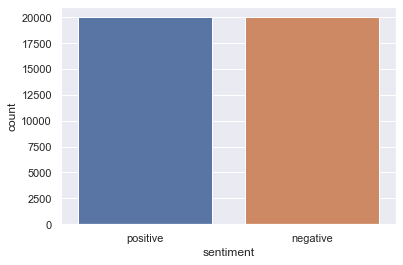

In [13]:
sns.countplot(df_train["sentiment"])
plt.show()

In [14]:
Neg = round(df_train["sentiment"].value_counts()[1]/len(df_train) * 100, 2)
Pos = round(df_train["sentiment"].value_counts()[0]/len(df_train) * 100, 2)


print('This train_dataset contain {}% Negative Sentiment tweet'.format(Neg))
print('This train_dataset contain {}% Positive Sentiment tweet'.format(Pos))

This train_dataset contain 49.98% Negative Sentiment tweet
This train_dataset contain 50.02% Positive Sentiment tweet


In [15]:
# create a label columns using manual label encoding
lab = {"positive":1,"negative":0}
df_train['label']= df_train["sentiment"].map(lab)
df_train.head()

,review,sentiment,label
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


In [16]:
# clean text
df_train["clean_review"] = df_train["review"].apply(lambda text : clean_review(text))

In [17]:
df_train.head()

,review,sentiment,label,clean_review
0,One of the other reviewers has mentioned that ...,positive,1,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,1,a wonderful little production br br the filmin...
2,I thought this was a wonderful way to spend ti...,positive,1,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,0,basically there s a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1,petter mattei s love in the time of money is a...


In [18]:
df_train = df_train[["clean_review", "label"]]

In [19]:
df_train.head()

,clean_review,label
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production br br the filmin...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically there s a family where a little boy ...,0
4,petter mattei s love in the time of money is a...,1


In [20]:
# check for missing values
df_train.isnull().sum()

# drop missing rows
# df_train = df_train.dropna()
# df_train.isnull().sum()

clean_review    0
label           0
dtype: int64

In [21]:
# convert training dataset into tensorflow dataset format
train_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(df_train["clean_review"].values, tf.string),
            tf.cast(df_train['label'].values, tf.int32)
        )
    )
)

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [22]:
# print first five records from train dataset
for example, label in train_dataset.take(5):
    print("--"*50)
    print("example : ", example.numpy())
    print()
    print("label: ", label.numpy())

----------------------------------------------------------------------------------------------------
example :  b'one of the other reviewers has mentioned that after watching just 1 oz episode you ll be hooked they are right as this is exactly what happened with me br br the first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not a show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the word br br it is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda em city is home to many aryans muslims gangstas latinos christians italians irish and more so scuffles death stares dodgy dealings and shady agreements are never f

In [23]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [24]:
# create batches of the dataset, where each batch will have 64 samples
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [25]:
# print first batch from train dataset

# for example, label in train_dataset.take(1):
#     print("example : ", example.numpy())
#     print("-----------------------")
#     print("label: ", label.numpy())
#     print("-----------------------")
#     print("total len: ", len(label.numpy()))

### 4. Creating your training and validation splits

In [26]:
# Create a validation dataset by taking the first 100 batches from the train dataset.
val_dataset = train_dataset.take(100) # 100 * 64 = 6400

# Remove the samples used for validation from the train dataset.
train_dataset = train_dataset.skip(100) # 40000 - 6400 = 33600

### Create the text encoder

the raw text data needs to be processed before it can be used in a model. The simplest way to process text for training is using the
textvectorization layer this layer has many capbiliites.

In [27]:
# Create the layer, and pass the dataset text to the layer's .adapt method

VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [28]:
# create vocabulary of words
vocab = np.array(encoder.get_vocabulary())

# print top 20 vocab
vocab[0:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'br', 'it', 'in',
       'i', 'this', 'that', 's', 'was', 'as', 'movie', 'for', 'with'],
      dtype='<U14')

In [29]:
len(vocab)

1000

In [30]:
encoded_example = encoder("This is dev a lksj l kwejr lk qwlerj lqwekjr  nice pen !").numpy()
encoded_example

array([ 12,   7,   1,   4,   1,   1,   1,   1,   1,   1, 337,   1],
      dtype=int64)

In [31]:
vocab[339]

'completely'

with default settings, the process is not completely reversible. Two reason for this are:-

**Standardization Method:** The default standardization method ("lower_and_strip_punctuation") lowers text and removes punctuation, making it irreversible without original casing and punctuation.

**Limited Vocabulary Size:** Limited vocabulary leads to unknown tokens for out-of-vocabulary words, making reconstruction difficult.

**To improve reversibility:**

Adjust standardization to preserve casing and punctuation if needed.  
Increase vocabulary size to minimize unknown tokens.  
Implement character-based fallback for better reconstruction in case of unknown tokens.

### 5. Defining your RNN model architecture

In [32]:
# create RNN model
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()),
                              output_dim=64,
                              mask_zero=True),

    tf.keras.layers.SimpleRNN(64, return_sequences=True),  # Ensure output sequences are returned
    tf.keras.layers.Dropout(0.2),  # Adding dropout layer
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dropout(0.2),  # Adding dropout layer
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

1. This model can be built as a `tf.keras.Sequential`.

2. The first layer is the encoder, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

4. A recurrent neural network (RNN) processes sequences input by iterating through the elements. RNNs pass the outputs from timestep to their input on the next timestep.
   - The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output.
   - The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.
   - The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequences to a single vector, the two `tf.keras.layers.Dense` layers do some final processing and convert from this vector representation to a single logit as the classification output. Ensure correct letter casing and grammar.

In [33]:
# pass sample input

sample_text = ("the movie was not so good. and animatioin and the graphics is worst, i would not recommend this movie")
encoded_sample = encoder([sample_text])
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 2s 2s/step
[[0.4977418]]


In [34]:
# play with models (uncomment one one layer at time and check the output)
model2 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=5, mask_zero=True),
    tf.keras.layers.SimpleRNN(5, return_sequences=True),  # Ensure output sequences are returned
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(5)),
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

sample_text = ("the movie was good alsdfj lkajsdf lakjds")
predictions = model2.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 2s 2s/step
[[0.4979081]]


### 6. Compiling your RNN model

In [35]:
# compile the model

# for binary classification
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

### 7. Training your model on your training data

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          64000     
                                                                 
 simple_rnn (SimpleRNN)      (None, None, 64)          8256      
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

In [37]:
EPOCHS = 20

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',  # Adjust based on the metric you want to monitor
    factor=0.2,  # Factor by which the learning rate will be reduced
    patience=2,  # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6  # Lower bound on the learning rate
)

# Train the model with callbacks
results = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping_callback, reduce_lr_callback]
)

Epoch 1/20
525/525 [==============================] - 1140s 2s/step - loss: 0.5614 - accuracy: 0.6890 - val_loss: 0.3770 - val_accuracy: 0.8317 - lr: 1.0000e-04
Epoch 2/20
525/525 [==============================] - 1131s 2s/step - loss: 0.3471 - accuracy: 0.8512 - val_loss: 0.3143 - val_accuracy: 0.8631 - lr: 1.0000e-04
Epoch 3/20
525/525 [==============================] - 1128s 2s/step - loss: 0.3240 - accuracy: 0.8636 - val_loss: 0.3036 - val_accuracy: 0.8695 - lr: 1.0000e-04
Epoch 4/20
525/525 [==============================] - 1187s 2s/step - loss: 0.3081 - accuracy: 0.8717 - val_loss: 0.3228 - val_accuracy: 0.8691 - lr: 1.0000e-04
Epoch 5/20
525/525 [==============================] - 1136s 2s/step - loss: 0.3025 - accuracy: 0.8728 - val_loss: 0.2925 - val_accuracy: 0.8725 - lr: 1.0000e-04
Epoch 6/20
525/525 [==============================] - 1149s 2s/step - loss: 0.2931 - accuracy: 0.8780 - val_loss: 0.2878 - val_accuracy: 0.8811 - lr: 1.0000e-04
Epoch 7/20
525/525 [==============

In [38]:
model.save("sentiment_model", save_format="tf")

INFO:tensorflow:Assets written to: sentiment_model\assets


INFO:tensorflow:Assets written to: sentiment_model\assets


### 8. Evaluating your model on your test data

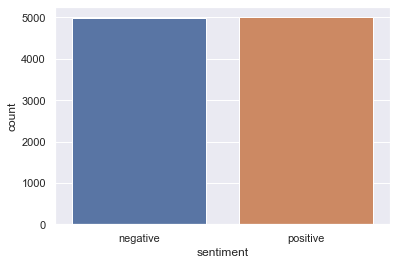

In [39]:
sns.countplot(df_test["sentiment"])
plt.show()

In [40]:
Neg = round(df_test["sentiment"].value_counts()[1]/len(df_test) * 100, 2)
Pos = round(df_test["sentiment"].value_counts()[0]/len(df_test) * 100, 2)
print('This train_dataset contain {}% Negative Sentiment tweet'.format(Neg))
print('This train_dataset contain {}% Positive Sentiment tweet'.format(Pos))

This train_dataset contain 49.93% Negative Sentiment tweet
This train_dataset contain 50.07% Positive Sentiment tweet


In [41]:
# clean text
df_test["clean_review"] = df_test["review"].apply(lambda text : clean_review(text))

# create a label columns using manual label encoding
lab = {"positive":1,"negative":0}
df_test['label']= df_test["sentiment"].map(lab)
df_test.head(10)

,review,sentiment,clean_review,label
40000,First off I want to say that I lean liberal on...,negative,first off i want to say that i lean liberal on...,0
40001,I was excited to see a sitcom that would hopef...,negative,i was excited to see a sitcom that would hopef...,0
40002,When you look at the cover and read stuff abou...,negative,when you look at the cover and read stuff abou...,0
40003,"Like many others, I counted on the appearance ...",negative,like many others i counted on the appearance o...,0
40004,"This movie was on t.v the other day, and I did...",negative,this movie was on t v the other day and i didn...,0
40005,Hickory Dickory Dock was a good Poirot mystery...,positive,hickory dickory dock was a good poirot mystery...,1
40006,"""One Crazy Summer"" is the funniest, craziest (...",positive,one crazy summer is the funniest craziest not ...,1
40007,Low-budget schlockmeister Herschell Gordon Lew...,negative,low budget schlockmeister herschell gordon lew...,0
40008,this was absolutely the most tragic pile of ci...,negative,this was absolutely the most tragic pile of ci...,0
40009,I have never understood the appeal of this sho...,negative,i have never understood the appeal of this sho...,0


In [42]:
df_test = df_test[["clean_review", "label"]]
df_test.head()

,clean_review,label
40000,first off i want to say that i lean liberal on...,0
40001,i was excited to see a sitcom that would hopef...,0
40002,when you look at the cover and read stuff abou...,0
40003,like many others i counted on the appearance o...,0
40004,this movie was on t v the other day and i didn...,0


In [43]:
# check missing values
df_test.isna().sum()

clean_review    0
label           0
dtype: int64

In [44]:
# convert test dataset into tensorflow dataset format
test_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(df_test["clean_review"].values, tf.string),
            tf.cast(df_test['label'].values, tf.int32)
        )
    )
)

# creeate batches in test dataset
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [45]:
# for example, label in test_dataset.take(1):
#     print("example : ", example.numpy())
#     print("-----------------------")
#     print("label: ", label.numpy())
#     print("-----------------------")
#     print("total len: ", len(label.numpy()))

In [46]:
test_loss, test_acc = model.evaluate(test_dataset)

157/157 [==============================] - 55s 349ms/step - loss: 0.3110 - accuracy: 0.8702


In [49]:
print("Test Loss: {}".format(test_loss))
print("Test Accuracy: {}".format(test_acc))

Test Loss: 0.3110285699367523
Test Accuracy: 0.870199978351593


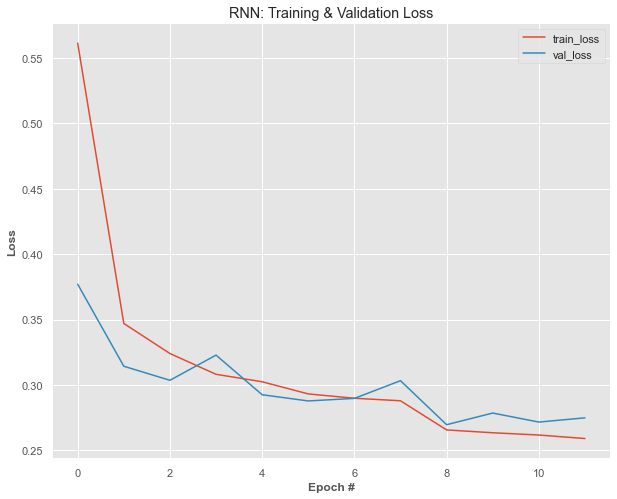

In [50]:
# plot the training and validation loss
N = np.arange(0, 12)
plt.style.use("ggplot")
plt.figure(figsize = [10,8])
plt.plot(N, results.history["loss"], label="train_loss")
plt.plot(N, results.history["val_loss"], label="val_loss")
plt.title("RNN: Training & Validation Loss")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Loss", weight="bold")
plt.legend()
plt.show()

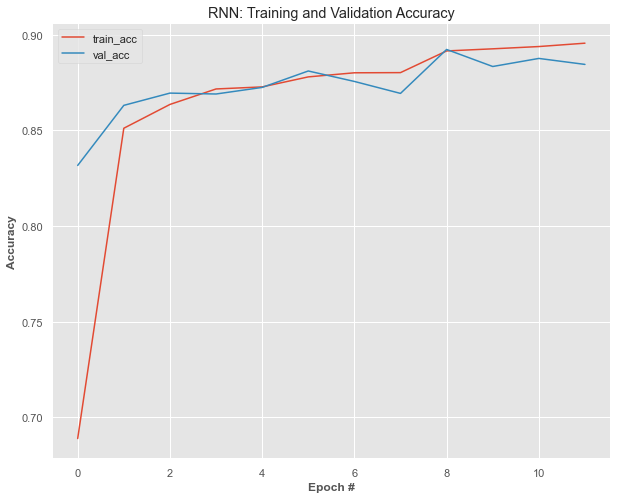

In [51]:
# plot the training and validation accuracy
N = np.arange(0, 12)
plt.style.use("ggplot")
plt.figure(figsize = [10,8])
plt.plot(N, results.history["accuracy"], label="train_acc")
plt.plot(N, results.history["val_accuracy"], label="val_acc")
plt.title("RNN: Training and Validation Accuracy")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Accuracy", weight="bold")
plt.legend()
plt.show()

In [52]:
# predict on a sample text

sample_text = ("The movie was  Good, I would recommend this movie.")

prediction = model.predict(np.array([sample_text]))
print(prediction)

if prediction[0][0] >= 0.5:
    print("positive")
else:
    print("negative")

1/1 [==============================] - 2s 2s/step
[[0.57542396]]
positive


### 9. Saving the model

In [53]:
# save the model to disk
print("[INFO] serializing network...")
model.save("sentiment_RNN_10epochs.model", save_format="tf")

[INFO] serializing network...


INFO:tensorflow:Assets written to: sentiment_RNN_10epochs.model\assets


INFO:tensorflow:Assets written to: sentiment_RNN_10epochs.model\assets


In [54]:
new_model = load_model("sentiment_model")
print("[INFO] model loaded succesfully..")

[INFO] model loaded succesfully..


In [55]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          64000     
                                                                 
 simple_rnn (SimpleRNN)      (None, None, 64)          8256      
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

### 10. Making predictions for unseen data

In [56]:
# check missing value
df_test.isnull().sum()

clean_review    0
label           0
dtype: int64

In [57]:
df_test.head()

,clean_review,label
40000,first off i want to say that i lean liberal on...,0
40001,i was excited to see a sitcom that would hopef...,0
40002,when you look at the cover and read stuff abou...,0
40003,like many others i counted on the appearance o...,0
40004,this movie was on t v the other day and i didn...,0


In [58]:
# prediction on unseen data
y_pred = model.predict(np.array(df_test["clean_review"]))
y_pred[:10]

313/313 [==============================] - 83s 265ms/step


array([[0.00355443],
       [0.0127899 ],
       [0.97194946],
       [0.00286975],
       [0.24069503],
       [0.9933396 ],
       [0.9831845 ],
       [0.00546294],
       [0.10258961],
       [0.00620028]], dtype=float32)

In [59]:
y_pred_bool = []
for conf in y_pred:
    if conf[0] >= 0.5:
        y_pred_bool.append(1)
    else:
        y_pred_bool.append(0)

df_test["pred"] = y_pred_bool

In [60]:
df_test.head()

,clean_review,label,pred
40000,first off i want to say that i lean liberal on...,0,0
40001,i was excited to see a sitcom that would hopef...,0,0
40002,when you look at the cover and read stuff abou...,0,1
40003,like many others i counted on the appearance o...,0,0
40004,this movie was on t v the other day and i didn...,0,0


### 11. confusion matrix & Classification report

Confusion Matrix, Without Normalisation


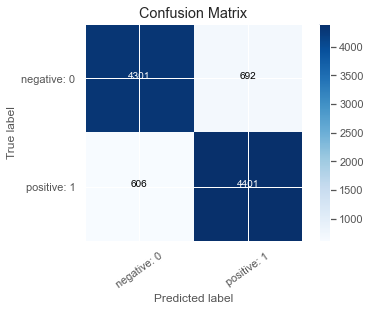

-----------------------------------------------------
Classification report
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      4993
           1       0.86      0.88      0.87      5007

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

-----------------------------------------------------
Accuracy of the model:  0.8702


In [61]:
plot_confusion_metrix(df_test["label"], df_test["pred"],classes=["negative: 0","positive: 1"])

### 12. final submission

In [62]:
def label(a):
    if a==0:
        return "Negative"
    elif a==1:
        return "Positive"

In [63]:
df_test["pred"] = df_test["pred"].apply(lambda a : label(a))
df_test["label"] = df_test["label"].apply(lambda a : label(a))

In [64]:
df_test.head()

,clean_review,label,pred
40000,first off i want to say that i lean liberal on...,Negative,Negative
40001,i was excited to see a sitcom that would hopef...,Negative,Negative
40002,when you look at the cover and read stuff abou...,Negative,Positive
40003,like many others i counted on the appearance o...,Negative,Negative
40004,this movie was on t v the other day and i didn...,Negative,Negative


In [65]:
df_test.to_csv("Test_Predictioin.csv", index=False)

### THE END

In [66]:
# Time taken to run the entire notebook/ Notebook Execution Time

end_time = time.time()

result = calculate_execution_time(start_time, end_time)
print(result)

Execution time: 241 minutes and 24.86 seconds
